<h1 align="center"><font color="yellow">Pytorch: VISUALIZANDO MODELOS, DADOS E TREINAMENTO COM O TENSORBOARD</font></h1>

<font color="yellow">Data Scientist.: PhD.Eddy Giusepe Chirinos Isidro</font>

Link de estudo:

* [Pytorch Tutorial](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)

In [ ]:
%pip install torchvision

In [1]:
%load_ext watermark 
%watermark -v -p numpy,pandas,matplotlib,torchvision

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.13.2

numpy      : 1.24.3
pandas     : 2.0.1
matplotlib : 3.7.1
torchvision: 0.15.2



In [2]:
# Importamos as Bibliotecas
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Função auxiliar para mostrar uma imagem
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        

In [3]:
# get some random training images
dataiter = iter(trainloader)

images, labels = next(dataiter)

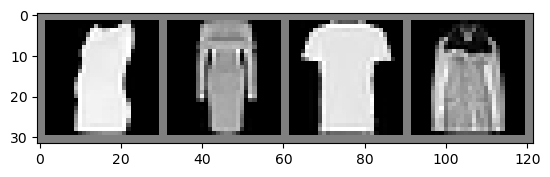

In [4]:
# shows as nossas Imagens
matplotlib_imshow(torchvision.utils.make_grid(images))

In [5]:
# print labels
batch_size = 4
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

T-shirt/top Dress T-shirt/top Coat 


Definiremos uma `arquitetura de modelo` semelhante a partir desse tutorial, fazendo apenas pequenas modificações para levar em conta o fato de que as imagens agora são `um canal` em vez de três e `28x28` em vez de `32x32`:

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


# 1. Configuração do TensorBoard

Agora vamos configurar o `TensorBoard`, importando `tensorboard` e `torch.utils` definindo um `SummaryWriter`, nosso objeto chave para gravar informações no TensorBoard.

In [8]:
from torch.utils.tensorboard import SummaryWriter

# Padrão `log_dir` is "runs" - seremos mais específicos aqui:
writer = SummaryWriter('runs/fashion_mnist_experiment_1')


Observe que esta linha sozinha cria uma pasta `runs/fashion_mnist_experiment_1`.

# 2. Escrevendo no TensorBoard

Agora vamos escrever uma imagem em nosso `TensorBoard` - especificamente, uma grade - usando [make_grid](https://pytorch.org/vision/stable/utils.html#torchvision.utils.make_grid).

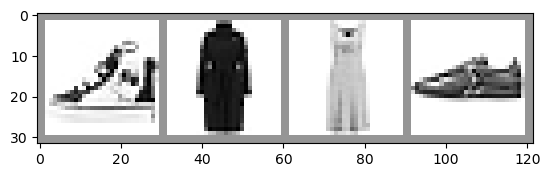

In [9]:
# Obtenha algumas imagens de treinamento aleatórias:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Criamos Grade de Imagens
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

<font color="orange">Agora em execução:</font>

In [10]:
%load_ext tensorboard

%tensorboard --logdir /home/eddygiusepe/1_Eddy_Giusepe/LightningAI/Modelo_Dados_Treinamento_Tensorboard/runs

Você pode navegar também no link [http://localhost:6006](http://localhost:6006).

Agora você já sabe como usar o `TensorBoard`! Este exemplo, no entanto, poderia ser feito em um `Jupyter Notebook` - onde o `TensorBoard` realmente se destaca na criação de visualizações interativas. Abordaremos um deles a seguir e vários outros até o final do tutorial.

# 3. Inspecione o modelo usando o TensorBoard

<font color="orange">Um dos pontos fortes do `TensorBoard` é sua capacidade de visualizar estruturas de modelo complexas. Vamos visualizar o modelo que construímos.</font>

In [11]:
writer.add_graph(net, images)
writer.close()

Você pode abrir a URL acima e atualizar! Você observará `GRAPHS` 

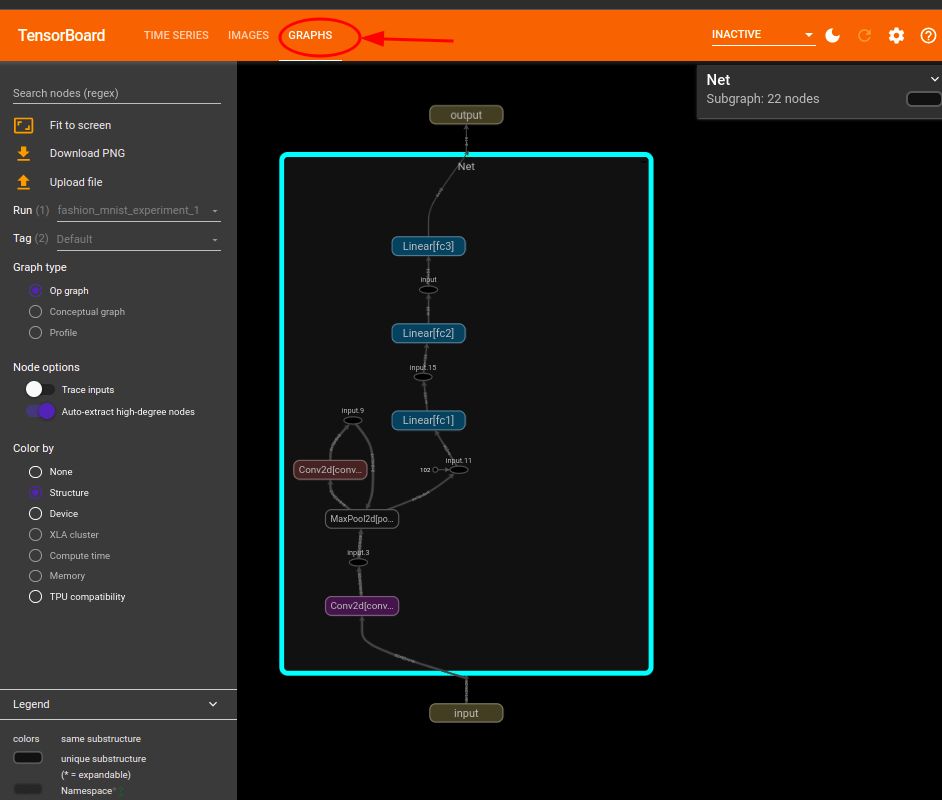

Vá em frente e clique duas vezes em `“Net”` para vê-lo expandido, tendo uma visão detalhada das operações individuais que compõem o modelo.

O `TensorBoard` possui um recurso muito útil para visualizar dados de alta dimensão, como dados de imagem em um espaço de dimensão inferior; abordaremos isso a seguir.

# 4. Adicionando um “Projetor” ao TensorBoard


Podemos visualizar a representação dimensional inferior de dados dimensionais superiores por meio do método [add_embedding](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_embedding).

In [12]:
# Função auxiliar: 
def select_n_random(data, labels, n=100):
    '''
    Seleciona n pontos de Dados aleatórios e seus rótulos correspondentesde um conjunto de Dados.
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Selecione imagens aleatórias e seus índices alvo.
images, labels = select_n_random(trainset.data, trainset.targets)

# Obter os rótulos de classe para cada imagem.
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1),
                    global_step=0) # Trocar por 1, se em caso existir o Diretório de Embeddings. 
writer.close()



Agora, na guia `"PROJETOR"` do `TensorBoard`, você pode ver essas $100$ imagens - cada uma com `784` dimensões - projetadas no espaço tridimensional. Além disso, é interativo: você pode clicar e arrastar para girar a projeção tridimensional. Por fim, algumas dicas para facilitar a visualização: selecione `“color: label”` no canto superior esquerdo, além de ativar o `“night mode”`, que facilitará a visualização das imagens, pois o fundo é branco:

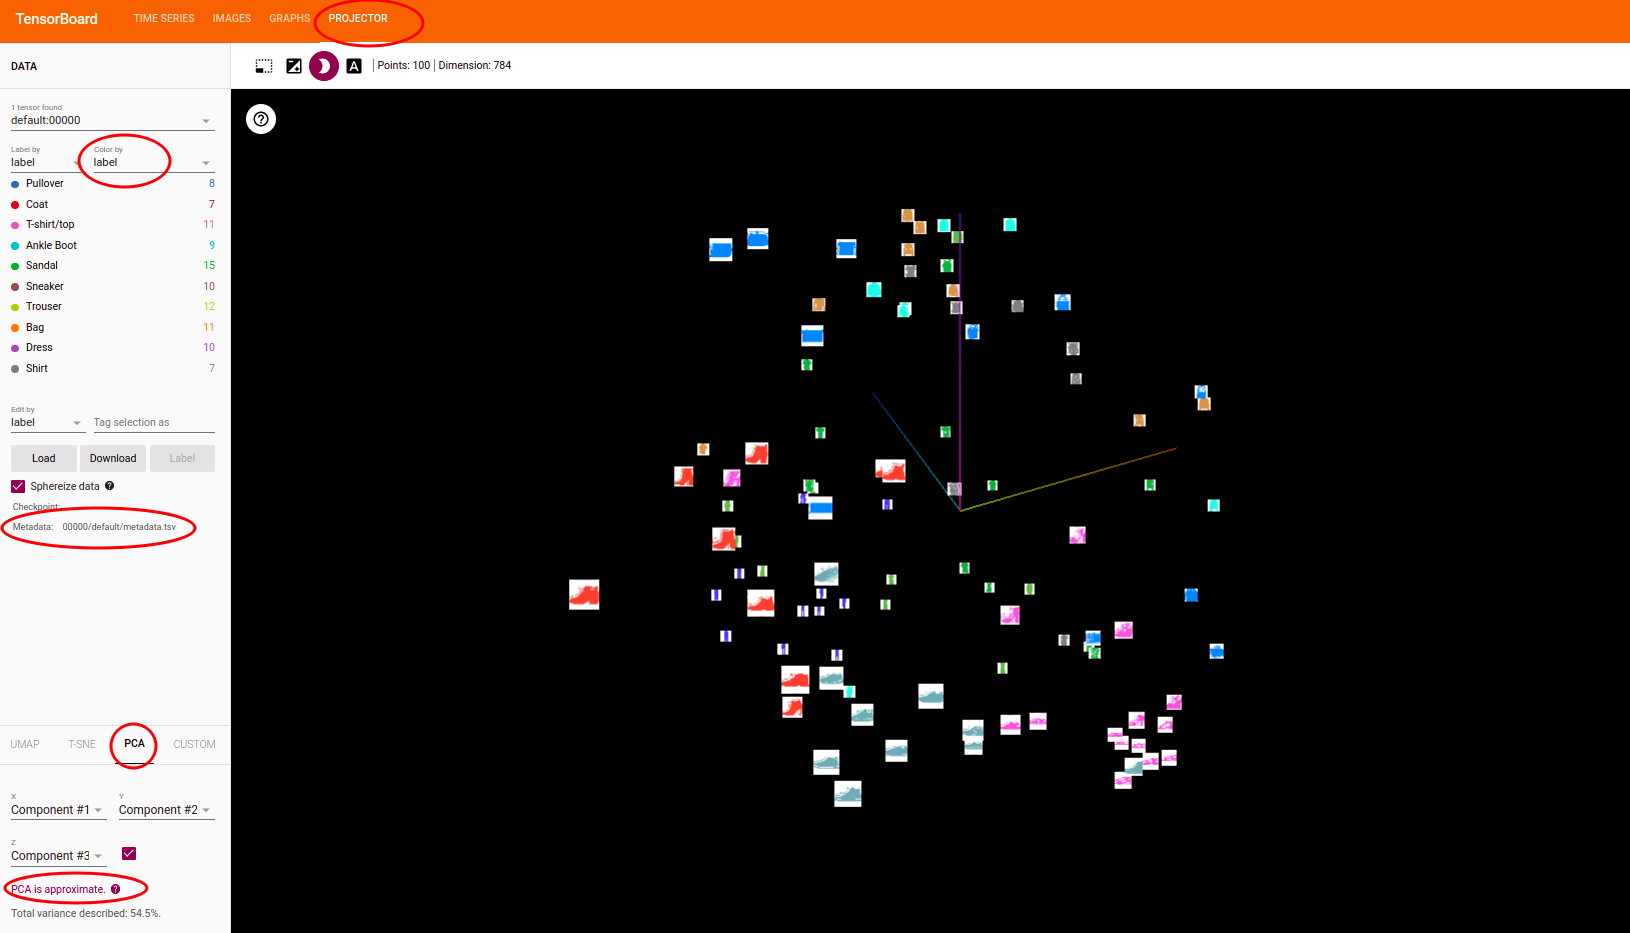

Agora que inspecionamos minuciosamente nossos dados, vamos mostrar como o `TensorBoard` pode tornar mais claro o `treinamento` e a `avaliação` do modelo de rastreamento (`tracking`), começando pelo treinamento.



# 5. Acompanhamento do Treinamento do modelo com o `TensorBoard`

No exemplo anterior, simplesmente imprimimos a perda de execução do modelo a cada `2000 iterações`. Agora, em vez disso, registraremos a perda contínua no `TensorBoard`, juntamente com uma visualização das previsões que o modelo está fazendo por meio da função `plot_classes_preds`.

In [13]:
# Funciones auxiliares:

def images_to_probs(net, images):
    '''
    Gera previsões e probabilidades correspondentes a partir de uma 
    Rede Treinada e uma lista de Imagens.
    '''
    output = net(images)
    # converter probabilidades de saída para classe prevista
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


Por fim, vamos treinar o modelo usando o mesmo código de treinamento do tutorial anterior, mas gravando os resultados no `TensorBoard` a cada `1000 lotes`, em vez de imprimir no console; isso é feito usando a função [add_scalar](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalar).


Além disso, à medida que treinamos, geraremos uma imagem mostrando as previsões do modelo versus os resultados reais nas quatro imagens incluídas nesse lote.

In [14]:
running_loss = 0.0
for epoch in range(1):  # Percorrer o conjunto de Dados várias vezes

    for i, data in enumerate(trainloader, 0):

        # Obter as entradas; data é uma lista de [inputs, labels]
        inputs, labels = data

        # Zerar os gradientes dos parâmetros
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # A cada 1000 mini-batches...

            # ...registrar (log) a Loss em execução
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Treinamento Finalizado!')



Treinamento Finalizado!


<font color="orange">Agora você pode consultar a guia de escalares para ver a Loss contínua plotada nas `15000` iterações de Treinamento:</font>

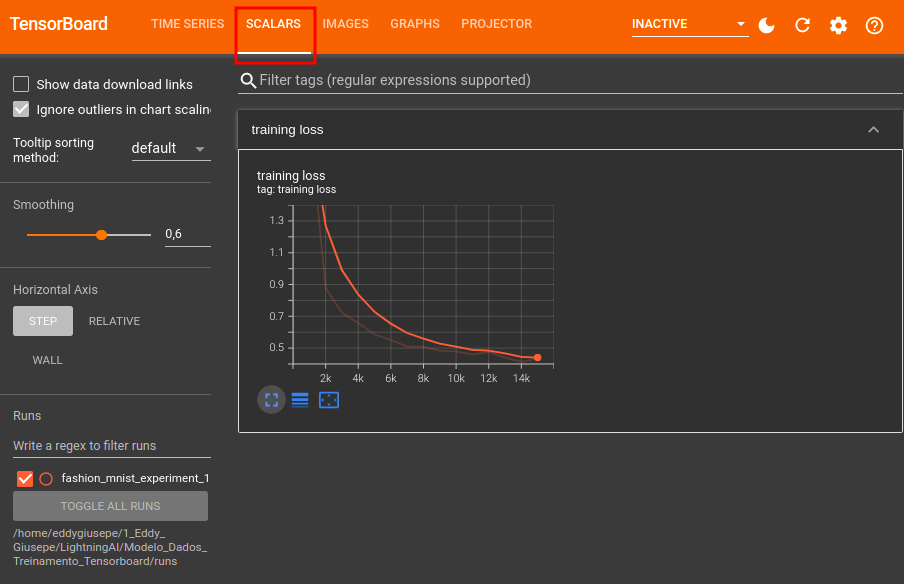

Além disso, podemos observar as previsões que o modelo fez em lotes arbitrários ao longo do aprendizado. Consulte a guia `“Imagens”` e role para baixo na visualização `“predictions` vs actuals”` para ver isso; isso nos mostra que, por exemplo, após apenas `3000 iterações de treinamento`, o modelo já era capaz de distinguir entre classes visualmente distintas, como `shirts`, `sneakers` e `coats`, embora não seja tão confiante quanto se torna mais tarde no treinamento:



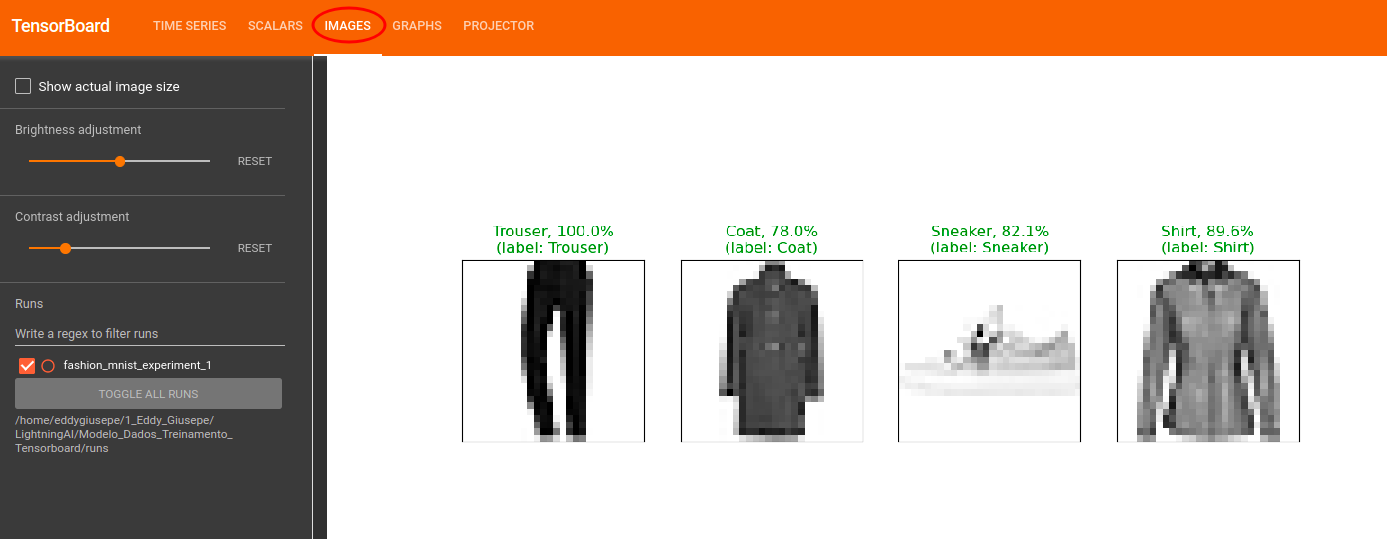

No tutorial anterior, analisamos a precisão por classe depois que o modelo foi treinado; aqui, usaremos o `TensorBoard` para traçar curvas de `precision - recall` (boa explicação [aqui](https://www.scikit-yb.org/en/latest/api/classifier/prcurve.html)) para cada classe.

# 